# Zoning Game Demo 0

## The Game

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nsai_experiments.deps import helpers
from nsai_experiments.zoning_game.zg_gym import ZoningGameEnv, ZoningGameObservationWrapper
from nsai_experiments import alphazero_torch as azt

In [3]:
myenv = ZoningGameEnv()
myenv.reset(seed=47)
print(myenv.render().read())

Tile grid:
[[0 0 0 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]
Tile queue (leftmost next): [1 4 2 1 5 2 3 3 2 3 1 1 1 4 2 2 1 5 5 2 1 5 3 2 5 1 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 0 moves, current grid score is 3; terminated = False, truncated = False.



In [4]:
myenv.step(2, on_invalid="warn")
print(myenv.render().read())

Tile grid:
[[0 0 1 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]
Tile queue (leftmost next): [4 2 1 5 2 3 3 2 3 1 1 1 4 2 2 1 5 5 2 1 5 3 2 5 1 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 1 moves, current grid score is 5; terminated = False, truncated = False.



In [5]:
myenv.step(2, on_invalid="warn")
print(myenv.render().read())

Tile grid:
[[0 0 1 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]
Tile queue (leftmost next): [4 2 1 5 2 3 3 2 3 1 1 1 4 2 2 1 5 5 2 1 5 3 2 5 1 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 2 moves, current grid score is 5; terminated = False, truncated = False.



## Learning to play

In [6]:
mywrapped = ZoningGameObservationWrapper(myenv)
mywrapped.step(2)

(array([0, 0, 1, 5, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 3, 2, 4, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 4, 2, 1, 5, 2, 3, 3, 2,
        3, 1, 1, 1, 4, 2, 2, 1, 5, 5, 2, 1, 5, 3, 2, 5, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 0,
 False,
 False,
 {})

In [7]:
# episode_returns,timepoints,a_best,seed_best,R_best = azt.agent(
#     game="zg/ZoningGameEnv-v0", n_ep=50, n_mcts=10, max_ep_len=300, lr=0.00001,
#     c=1.5, gamma=1.0, data_size=1000, batch_size=32, temp=1.0, n_hidden_layers=2, n_hidden_units=128, nsites=20)

In [8]:
# def plot_results(episode_returns, window=10):
#     fig,ax = plt.subplots(1,figsize=[7,5])
#     total_eps = len(episode_returns)
#     episode_returns_smoothed = helpers.smooth(episode_returns,window,mode='valid') 
#     ax.plot(helpers.symmetric_remove(np.arange(total_eps),window-1),episode_returns_smoothed,linewidth=4,color='darkred')
#     ax.set_ylabel('Return')
#     ax.set_xlabel('Episode',color='darkred')
#     plt.plot()
# plot_results(episode_returns)

## Rules

Generate a random rule from the probabilistic context free grammar:

In [9]:
from nsai_experiments.zoning_game.zg_cfg import ZONING_GAME_GRAMMAR, generate_one_probabilistic, format_ruleset
my_ruleset = format_ruleset(generate_one_probabilistic(ZONING_GAME_GRAMMAR, seed=42))
print(my_ruleset)

DOWNTOWN must ( form_cluster_with_fewer_than 4 tiles or ( ( not ( not form_cluster_with_fewer_than 5 tiles ) ) or ( not ( be_within 5 tiles_of BOARD_VERTICAL_MEDIAN and ( not form_cluster_with_fewer_than 4 tiles ) ) ) ) ) ;
RESIDENTIAL must be_within 5 tiles_of COMMERCIAL ;
INDUSTRIAL must ( be_within 5 tiles_of BOARD_EDGE and form_fewer_than 2 separate_clusters ) ;
RESIDENTIAL must ( form_fewer_than 4 separate_clusters or form_fewer_than 3 separate_clusters ) ;
INDUSTRIAL must be_within 4 tiles_of BOARD_CORNER ;
COMMERCIAL must ( not form_cluster_with_fewer_than 1 tiles ) ;
INDUSTRIAL must form_fewer_than 3 separate_clusters ;



Parse it to an AST:

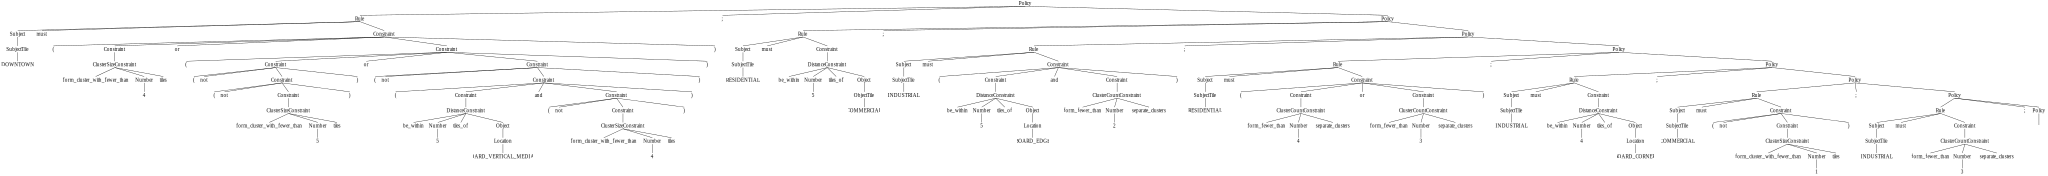

In [10]:
from nsai_experiments.zoning_game.zg_cfg import parse_to_ast
my_ast = parse_to_ast(my_ruleset)
my_ast

Parse it to an internal `NamedTuple`-based representation that is easier to work with:

In [11]:
from nsai_experiments.zoning_game.zg_cfg import parse_to_nt
my_nt = parse_to_nt(my_ruleset)
my_nt

[Rule(subject=<Tile.DOWNTOWN: 4>, constraint=Or(sub1=ClusterSizeConstraint(size=4), sub2=Or(sub1=Not(sub=Not(sub=ClusterSizeConstraint(size=5))), sub2=Not(sub=And(sub1=DistanceConstraint(distance=5, object=<Location.BOARD_VERTICAL_MEDIAN: 3>), sub2=Not(sub=ClusterSizeConstraint(size=4))))))),
 Rule(subject=<Tile.RESIDENTIAL: 1>, constraint=DistanceConstraint(distance=5, object=<Tile.COMMERCIAL: 2>)),
 Rule(subject=<Tile.INDUSTRIAL: 3>, constraint=And(sub1=DistanceConstraint(distance=5, object=<Location.BOARD_EDGE: 1>), sub2=ClusterCountConstraint(count=2))),
 Rule(subject=<Tile.RESIDENTIAL: 1>, constraint=Or(sub1=ClusterCountConstraint(count=4), sub2=ClusterCountConstraint(count=3))),
 Rule(subject=<Tile.INDUSTRIAL: 3>, constraint=DistanceConstraint(distance=4, object=<Location.BOARD_CORNER: 2>)),
 Rule(subject=<Tile.COMMERCIAL: 2>, constraint=Not(sub=ClusterSizeConstraint(size=1))),
 Rule(subject=<Tile.INDUSTRIAL: 3>, constraint=ClusterCountConstraint(count=3))]

"Interpret" it on a given tile in a tile grid: return whether that tile in its current context complies with all the relevant rules:

In [12]:
from nsai_experiments.zoning_game.zg_cfg import interpret_indiv
print(myenv.tile_grid)

import logging
logging.basicConfig(level=logging.DEBUG)
interpret_indiv(my_ruleset, myenv.tile_grid, 0, 4)

INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.RESIDENTIAL at (0, 4)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!


[[0 0 1 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]


True

Interpret a whole grid, producing a Boolean array containing the result for each tile:

In [13]:
from nsai_experiments.zoning_game.zg_cfg import interpret_grid

interpret_grid(my_ruleset, myenv.tile_grid)

INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.EMPTY at (0, 0)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.EMPTY at (0, 1)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.RESIDENTIAL at (0, 2)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.PARK at (0, 3)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.RESIDENTIAL at (0, 4)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.EMPTY at (0, 5)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.zoning_game.zg_cfg:Interpreting on Tile.EMPTY at (1, 0)
INFO:nsai_experiments.zoning_game.zg_cfg:  - tile complies!
INFO:nsai_experiments.z

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True, False,  True, False, False,  True],
       [ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False,  True]])

## Policies

A policy function is a function from an observation to an action. Often we will use a function that returns a policy function to fix some state across calls, such as a random number generator. The convenience function `play_one_game` takes a policy function and optionally an environment (else creates its own) and plays the environment with the policy function up to termination or truncation, returning the environment and the results of the final `step`.

In [14]:
from nsai_experiments.zoning_game.zg_policy import play_one_game, create_policy_random
my_policy_random = create_policy_random(seed=42)
final_env = play_one_game(my_policy_random, seed=47, on_invalid="warn")[0]
print(final_env.render().read())

INFO:nsai_experiments.zoning_game.zg_gym:Finished with reward 25


Tile grid:
[[3 3 1 5 1 3]
 [5 4 2 5 1 2]
 [1 3 5 3 2 4]
 [1 1 5 1 2 2]
 [2 4 3 1 4 2]
 [5 2 2 1 3 1]]
Tile queue (leftmost next): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 26 moves, current grid score is 25; terminated = True, truncated = False.



`policy_indiv_greedy` maximizes the individual score of the tile about to be placed, breaking ties randomly:

In [15]:
from nsai_experiments.zoning_game.zg_policy import create_policy_indiv_greedy
my_policy_indiv_greedy = create_policy_indiv_greedy(seed=42)
final_env = play_one_game(my_policy_indiv_greedy, seed=47, on_invalid="warn")[0]
print(final_env.render().read())

INFO:nsai_experiments.zoning_game.zg_gym:Finished with reward 56


Tile grid:
[[1 5 1 5 1 1]
 [1 4 2 3 1 2]
 [3 3 3 3 2 4]
 [5 2 5 2 4 4]
 [2 1 5 5 2 2]
 [1 2 3 1 3 1]]
Tile queue (leftmost next): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 26 moves, current grid score is 56; terminated = True, truncated = False.



`policy_total_greedy` maximizes the total grid score immediately after the current tile is placed, breaking ties randomly:

In [16]:
from nsai_experiments.zoning_game.zg_policy import create_policy_total_greedy
my_policy_total_greedy = create_policy_total_greedy(seed=42)
final_env = play_one_game(my_policy_total_greedy, seed=47, on_invalid="warn")[0]
print(final_env.render().read())

INFO:nsai_experiments.zoning_game.zg_gym:Finished with reward 54


Tile grid:
[[2 4 1 5 1 1]
 [2 4 1 1 1 5]
 [5 3 2 3 2 4]
 [1 3 3 3 2 4]
 [2 1 3 2 5 2]
 [1 5 5 2 3 1]]
Tile queue (leftmost next): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 26 moves, current grid score is 54; terminated = True, truncated = False.



`test_policy_intercomparison` in the test suite verifies that on average, `policy_total_greedy` outperforms `policy_indiv_greedy` and both outperform the random policy.

## CFG Policies

`create_policy_cfg_with_fallback` creates a policy that evaluates a ruleset from the grammar to determine valid moves, then relies on a fallback policy in the case that there are multiple valid moves. `evaluate_ruleset` is a convenience function to see how that compares to some control policy across multiple games. By default we use `control_policy_creator = fallback_policy_creator = create_policy_indiv_greedy`. The first value returned is the total reward on a policy that complies with the ruleset where possible and the second is the total reward on a control policy that does not respect the ruleset. 

In [17]:
from nsai_experiments.zoning_game.zg_cfg_policy import evaluate_ruleset
logging.getLogger("nsai_experiments.zoning_game.zg_cfg").setLevel(logging.ERROR)
logging.getLogger("nsai_experiments.zoning_game.zg_gym").setLevel(logging.ERROR)

# Intuitively, since the fallback policy already maximizes individual tile score, the
# policies we want here are those that consider externalities -- increase positive side
# effects, or decrease negative side effects, on other tiles.
evaluate_ruleset("INDUSTRIAL must ( not be_within 1 tiles_of RESIDENTIAL ) ;")

(5846,
 5475,
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 1.2741481325691852,
   <Tile.COMMERCIAL: 2>: 4.149119047619047,
   <Tile.INDUSTRIAL: 3>: 0.6782539682539682,
   <Tile.DOWNTOWN: 4>: 1.983952380952381,
   <Tile.PARK: 5>: 0.3203333333333333}},
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 0.720013940007361,
   <Tile.COMMERCIAL: 2>: 4.249738095238095,
   <Tile.INDUSTRIAL: 3>: 0.7714206349206348,
   <Tile.DOWNTOWN: 4>: 2.2931587301587304,
   <Tile.PARK: 5>: 0.45883333333333326}})

We conclude that this ruleset is better than no ruleset! However, an individually greedy policy with this ruleset is not better than a total greedy policy with no ruleset:

In [18]:
evaluate_ruleset("INDUSTRIAL must ( not be_within 1 tiles_of RESIDENTIAL ) ;", control_policy_creator=create_policy_total_greedy)

(5846,
 6493,
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 1.2741481325691852,
   <Tile.COMMERCIAL: 2>: 4.149119047619047,
   <Tile.INDUSTRIAL: 3>: 0.6782539682539682,
   <Tile.DOWNTOWN: 4>: 1.983952380952381,
   <Tile.PARK: 5>: 0.3203333333333333}},
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 1.4966336339099495,
   <Tile.COMMERCIAL: 2>: 4.4698095238095235,
   <Tile.INDUSTRIAL: 3>: 0.5825952380952379,
   <Tile.DOWNTOWN: 4>: 2.255015873015873,
   <Tile.PARK: 5>: 0.7969999999999999}})

I expect — but this should be shown by example — that there exists a ruleset for which the individual greedy result on that ruleset outperforms the total greedy result on no ruleset. Intuitively, this ruleset should work by "planning for the future," e.g., by saving space in the center of the grid for future `DOWNTOWN` tiles, which the total greedy policy is unable to do. Here's my best attempt so far:

In [19]:
evaluate_ruleset("""
                 INDUSTRIAL must ( ( not be_within 1 tiles_of RESIDENTIAL ) and ( not be_within 1 tiles_of DOWNTOWN ) ) ;
                 INDUSTRIAL must form_fewer_than 4 separate_clusters ;
                 DOWNTOWN must ( be_within 1 tiles_of DOWNTOWN or be_within 1 tiles_of COMMERCIAL ) ;
                 PARK must be_within 1 tiles_of RESIDENTIAL ;

                 INDUSTRIAL must ( not be_within 1 tiles_of BOARD_CENTER ) ;
                 PARK must ( not be_within 1 tiles_of BOARD_CENTER ) ;
                 RESIDENTIAL must ( not be_within 1 tiles_of BOARD_CENTER ) ;
                 COMMERCIAL must ( not be_within 1 tiles_of BOARD_CENTER ) ;

                 """, control_policy_creator=create_policy_total_greedy, env_seeds=range(10, 100+10))

(70384,
 71820,
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 1.3946043358602183,
   <Tile.COMMERCIAL: 2>: 4.221896248196248,
   <Tile.INDUSTRIAL: 3>: 0.6746849927849928,
   <Tile.DOWNTOWN: 4>: 3.812254473304473,
   <Tile.PARK: 5>: 0.16464285714285715}},
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 1.5953705048434537,
   <Tile.COMMERCIAL: 2>: 4.5220648629148625,
   <Tile.INDUSTRIAL: 3>: 0.6177674603174603,
   <Tile.DOWNTOWN: 4>: 2.319564502164502,
   <Tile.PARK: 5>: 1.183164285714286}})

We conclude with a playground where other policies can be quickly tested out:

In [20]:
evaluate_ruleset("""
                 INDUSTRIAL must ( ( not be_within 1 tiles_of RESIDENTIAL ) and ( not be_within 1 tiles_of DOWNTOWN ) ) ;
                 INDUSTRIAL must form_fewer_than 4 separate_clusters ;
                 DOWNTOWN must ( be_within 1 tiles_of DOWNTOWN or be_within 1 tiles_of COMMERCIAL ) ;
                 PARK must be_within 1 tiles_of RESIDENTIAL ;

                 INDUSTRIAL must ( not be_within 1 tiles_of BOARD_CENTER ) ;
                 PARK must ( not be_within 1 tiles_of BOARD_CENTER ) ;
                 RESIDENTIAL must ( not be_within 1 tiles_of BOARD_CENTER ) ;
                 COMMERCIAL must ( not be_within 1 tiles_of BOARD_CENTER ) ;

                 """, skip_control=True, env_seeds=range(10, 100+10))

(70384,
 {'average_scores': {<Tile.RESIDENTIAL: 1>: 1.3946043358602183,
   <Tile.COMMERCIAL: 2>: 4.221896248196248,
   <Tile.INDUSTRIAL: 3>: 0.6746849927849928,
   <Tile.DOWNTOWN: 4>: 3.812254473304473,
   <Tile.PARK: 5>: 0.16464285714285715}})

In [21]:
# Rules to come back to:
# 68838 PARK must ( form_cluster_with_fewer_than 1 tiles or be_within 2 tiles_of BOARD_CENTER ) ;
# 69139 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and be_within 1 tiles_of EMPTY ) ) ;
# 70384 PARK must be_within 1 tiles_of RESIDENTIAL ;
# 69050 PARK must be_within 2 tiles_of RESIDENTIAL ;
# 69100 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and be_within 2 tiles_of RESIDENTIAL ) ) ;
# 68979 PARK must ( be_within 1 tiles_of RESIDENTIAL or be_within 1 tiles_of DOWNTOWN ) ;
# 69147 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and form_cluster_with_fewer_than 1 tiles ) ) ;
# 68861 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and ( form_cluster_with_fewer_than 1 tiles and be_within 2 tiles_of RESIDENTIAL ) ) ) ;
# 70027 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and ( form_cluster_with_fewer_than 1 tiles and be_within 2 tiles_of BOARD_CENTER ) ) ) ;
# 69906 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and be_within 2 tiles_of BOARD_CENTER ) ) ;
# 70154 PARK must ( be_within 1 tiles_of RESIDENTIAL or ( be_within 1 tiles_of DOWNTOWN and ( form_cluster_with_fewer_than 1 tiles and ( be_within 2 tiles_of BOARD_CENTER and ( not be_within 1 tiles_of INDUSTRIAL ) ) ) ) ) ;
# 70104 PARK must ( be_within 1 tiles_of RESIDENTIAL and form_cluster_with_fewer_than 1 tiles ) ;

# 69170 COMMERCIAL must ( ( not be_within 1 tiles_of BOARD_VERTICAL_MEDIAN ) or ( not be_within 1 tiles_of BOARD_VERTICAL_MEDIAN ) ) ;

## Misc

We have a pair of deterministic policies, `policy_indiv_greedy_deterministic` and `policy_total_greedy_deterministic`, that are like their normal counterparts except they break ties by tile index (lower is better) rather than randomly. These might be useful for training ML models to mimic the policies. We'll quickly test here that their performance is not drastically different from the random ones:

In [22]:
from nsai_experiments.zoning_game.zg_policy import create_policy_indiv_greedy_deterministic, create_policy_total_greedy_deterministic

# Evaluating an empty ruleset is the same as just evaluating the fallback policy
print(evaluate_ruleset("", fallback_policy_creator=create_policy_indiv_greedy_deterministic, control_policy_creator=create_policy_indiv_greedy)[0:2])
print(evaluate_ruleset("", fallback_policy_creator=create_policy_total_greedy_deterministic, control_policy_creator=create_policy_total_greedy)[0:2])

(5220, 5475)
(6860, 6493)


Confirmed!